# Kalman Filter Parameter Optimization using Genetic Algorithm

In [1]:
# imports
import numpy as np
import array
from deap import base, creator, tools, algorithms
from KalmanFilter import KalmanFilter
from SignalGenerator import SignalGenerator
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import json
import datetime
import os
from tabulate2 import tabulate
import multiprocessing
from scoop import futures

## Support Functions Definitions

In [2]:
# Define the evaluation function
def evaluate(individual):
    q_val, r_val = individual
    #f_val, h_val, q_val, r_val = individual
    #F = np.array([[f_val]])
    #H = np.array([[h_val]])
    F = np.array([[1]])
    H = np.array([[1]])
    Q = np.array([[q_val]])
    R = np.array([[r_val]])
    P = np.array([[0]])
    x = np.array([[0]])

    # Add noise to create noisy measurement
    noise_std = random.uniform(0.1, 2)
    noisy_signal = SigGen.add_noise(true_signal, noise_std)
    kf = KalmanFilter(F, H, Q, R, P, x)
    filtered_signal = kf.filter(noisy_signal)
    rmsev = kf.calculate_rms_value_error(true_signal, filtered_signal)/true_signal_rms_value
    _, rmse = kf.calculate_error(true_signal, filtered_signal)
    return rmsev, rmse,

In [3]:
def select_with_elitism_and_diversity(population, n, halloffame, diversity_count=-1, tournsize=3):
    """
    Selects individuals for the next generation by combining elitism, tournament
    selection, and random sampling.

    Parameters:
    -----------
    population : list
        A list of individuals from which to select.
    n : int
        The number of individuals to select.
    halloffame : HallOfFame
        The hall of fame containing the best individuals.
    diversity_count : int, optional  (default=-1 for 10% of the population)
        The number of random individuals to add for diversity.
    tournsize : int, optional
        The tournament size for selection.

    Returns:
    --------
    list
        A new list of individuals for the next generation, containing the
        best individuals from the hall of fame, the winners of the
        tournament selection, and a few random individuals.
    """
    # Number of elite individuals to preserve
    elite_count = len(halloffame)
    # Number of random individuals to add for diversity
    if diversity_count < 0:
        diversity_count = int(0.1 * n)
        # Ensure we don't request a negative count from tournament selection
    tournament_count = max(0, n - elite_count - diversity_count)
    # First, use an existing selection (tournament) to choose the rest
    selected = tools.selTournament(population, tournament_count, tournsize)
    # Add elite individuals from hall of fame
    selected.extend(toolbox.clone(ind) for ind in halloffame)
    # Add random individuals for diversity
    for _ in range(diversity_count):
        selected.append(toolbox.individual())
    # Ensure we return exactly n individuals
    if len(selected) > n:
        selected = selected[:n]
    elif len(selected) < n:
        # Add more tournament selected individuals if needed
        additional = tools.selTournament(population, n - len(selected), tournsize)
        selected.extend(additional)
    return selected

In [4]:
def evolve_with_elitism(pop, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose: bool = False):
    """
    Executes a genetic algorithm with elitism, where the best individual is
    preserved between generations.

    Parameters:
    -----------
    toolbox : Toolbox
        A DEAP toolbox containing the genetic operators.
    pop : list
        A list of individuals representing the population.
    cxpb : float
        The probability of mating two individuals (crossover probability).
    mutpb : float
        The probability of mutating an individual.
    ngen : int
        The number of generations to evolve.
    stats : Statistics, optional
        A DEAP Statistics object to compile statistics.
    halloffame : HallOfFame, optional
        A DEAP HallOfFame object to preserve the best individuals.
    verbose : bool, optional
        Whether or not to print the statistics.

    Returns:
    --------
    pop : list
        The final population.
    logbook : Logbook
        A record of the statistics for each generation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    not_progress_bar = False
    if verbose:
        not_progress_bar = True

    # Evaluate the initial population
    for ind in tqdm(pop, desc="Evaluating First Generation"):
        ind.fitness.values = toolbox.evaluate(ind)

    for gen in tqdm(range(ngen), desc="Evolving Generations", disable=not_progress_bar):
        # Apply elitism: Find the best individual and clone it
        best_ind = toolbox.clone(tools.selBest(pop, k=1)[0])

        # Select the next generation
        offspring = toolbox.select(pop, len(pop) - 1)
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation to offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Add the elite individual to the next generation
        del best_ind.fitness.values
        offspring.append(best_ind)

        # Evaluate the offspring
        for ind in offspring:
            if not ind.fitness.valid:
                ind.fitness.values = toolbox.evaluate(ind)

        pop[:] = offspring  # Replace the current population with the new generation

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(pop)

        # Record statistics
        record = stats.compile(pop) if stats else {}
        logbook.record(gen=gen, nevals=len(pop), **record)
        if verbose:
            print(logbook.stream)

    if not verbose:
        floatfmt = [None, None, ".8f", ".8f", ".8f", ".8f"]
        print("Last 10 Generations' Fitness:")
        # Get the headers and values from the logbook chapter
        chapter = logbook.chapters["fitness"][-10:]  # Last 10 generations
        # Recover the data labels (header) of the "fitness" chapter
        data_labels = [label for i, label in enumerate(chapter[0].keys())]
        # Move the last two columns to the beginning
        table_header = data_labels[-2:] + data_labels[:-2]
        table_values = [[entry[col] for col in table_header] for entry in chapter]
        # Print the table
        print(tabulate(table_values, headers=table_header, tablefmt="simple_outline", floatfmt=floatfmt))

    return pop, logbook

## Create a synthetic signal

In [5]:
# Signal parameters
frequency = 480  # Hz
sampling_rate = 20000  # Hz
duration = 0.2  # seconds (200 ms)
amplitude = 0.1
offset = 0.1

SigGen = SignalGenerator(frequency, sampling_rate, duration, amplitude)

# Generate a clean 400 Hz sine wave
true_signal = SigGen.generate_signal('square')
true_signal = SigGen.add_offset(true_signal, offset)

# Add noise to create noisy measurement
noise_std = 0.5
noisy_signal = SigGen.add_noise(true_signal, noise_std)

# Get time vector
time= SigGen.get_time()

## Kalman Filter Matrices

### State Space Matrices
- F (State Transition Matrix): Describes how the state evolves from one time step to the next without external influences.
- H (Observation Matrix): Maps the state vector to the measurement space.

### Noise Covariance Matrices
- Q (Process Noise Covariance): Represents uncertainty in the state transition model.
- R (Measurement Noise Covariance): Represents uncertainty in the measurements.

### State Estimation Matrices
- P (State Covariance Matrix): Represents uncertainty in the current state estimate.
- x (State Vector): The actual state estimate the filter is computing.

## Plot the original, noisy, and reference filtered signals

MSE: 0.053138
RMSE: 0.230516
True Signal RMS Value: 0.140855
Filtered Signal RMS Value: 0.263582
RMS Value Error: 0.122727


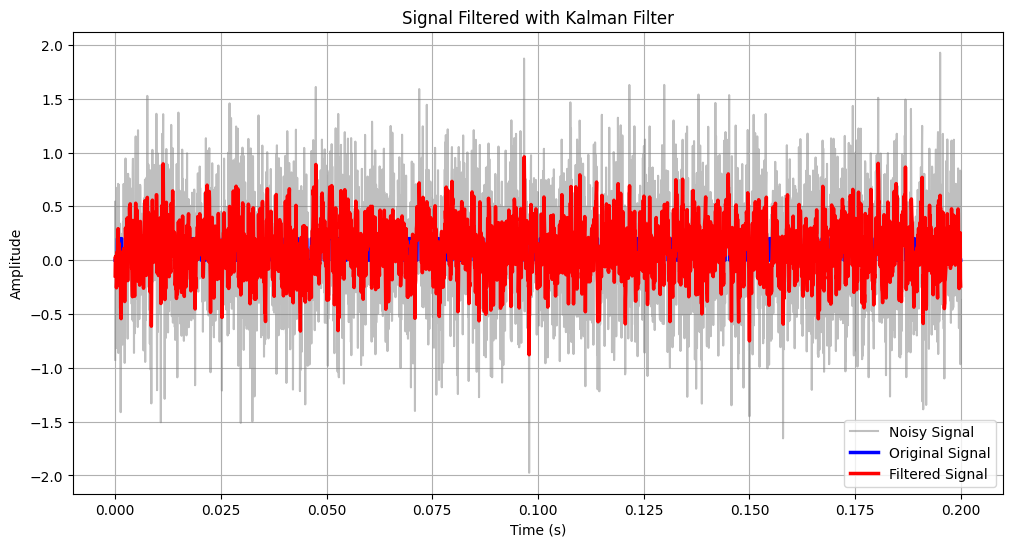

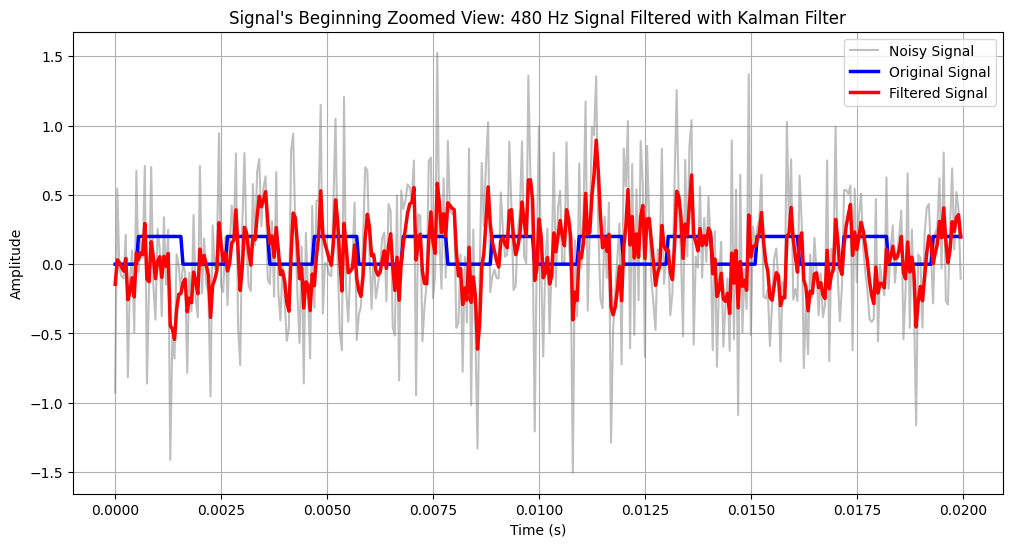

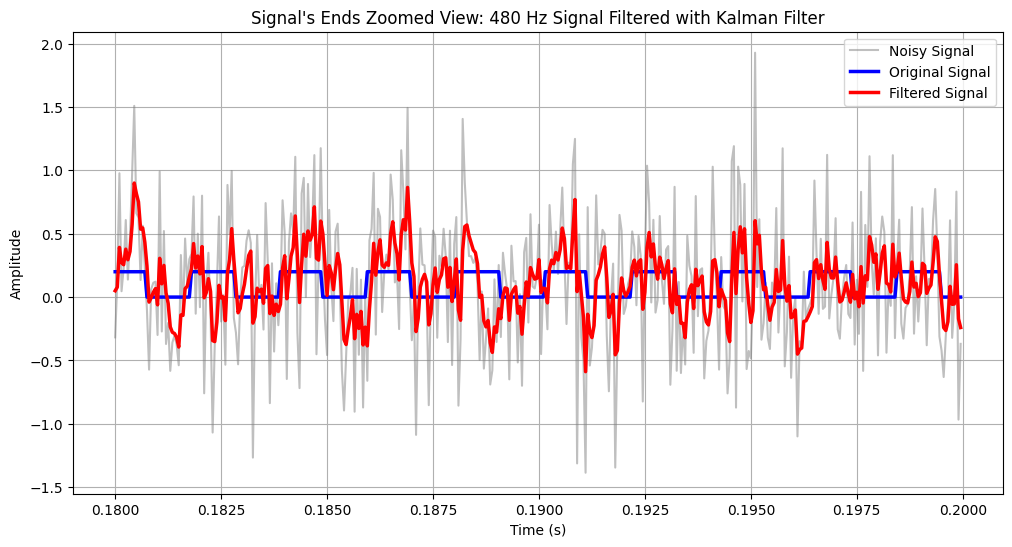

In [6]:
# Initialize Kalman filter
F = np.array([[1]])
H = np.array([[1]])
Q = np.array([[18.679136]])
R = np.array([[100]])
P = np.array([[0]])
x = np.array([[0]])

# Create and apply filter
kf = KalmanFilter(F, H, Q, R, P, x)
filtered_signal = kf.filter(noisy_signal)

# Calculate error metrics
mse, rmse = kf.calculate_error(true_signal, filtered_signal)
print(f'MSE: {mse:.6f}')
print(f'RMSE: {rmse:.6f}')

true_signal_rms_value = kf.calculate_rms_value(true_signal)
filtered_signal_rms_value = kf.calculate_rms_value(filtered_signal)
rms_value_error = kf.calculate_rms_value_error(true_signal, filtered_signal)
print(f'True Signal RMS Value: {true_signal_rms_value:.6f}')
print(f'Filtered Signal RMS Value: {filtered_signal_rms_value:.6f}')
print(f'RMS Value Error: {rms_value_error:.6f}')

# Plot results
kf.plot_results(noisy_signal, true_signal, filtered_signal, time)
kf.plot_results(noisy_signal, true_signal, filtered_signal, time, zoom_end=0.1, title=f'Signal\'s Beginning Zoomed View: {frequency} Hz Signal Filtered with Kalman Filter')
kf.plot_results(noisy_signal, true_signal, filtered_signal, time, zoom_begin=0.9, title=f'Signal\'s Ends Zoomed View: {frequency} Hz Signal Filtered with Kalman Filter')



## Setup the Genetic Algorithm

In [7]:
# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-2.0, -1.0))  # Minimize the RMSv and RMSE
creator.create("Individual", array.array, typecode="d", fitness=creator.FitnessMin)  # Create individuals as arrays

# Create the toolbox for genetic operations
toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, 1e-9, 5e3) # Random float for F, H, Q and R in the range [1e-6, 1e3]
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2) # Each individual has four parameters: Q and R
#toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4) # Each individual has four parameters: F, H, Q and R
toolbox.register("population", tools.initRepeat, list, toolbox.individual) # Create the genetic operations
toolbox.register("mate", tools.cxBlend, alpha=0.5) # Blend crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2) # Gaussian mutation
toolbox.register("evaluate", evaluate) # Evaluation function to calculate RMSE for each individual

# Preserve the best individual
halloffame = tools.HallOfFame(5)
#toolbox.register("select", tools.selTournament, tournsize=3) # Default Tournament selection
# Register the custom selection method to include elitism and diversity
toolbox.register("select", select_with_elitism_and_diversity, halloffame=halloffame, diversity_count=-1)  # 10% diversity individuals

# Statistics to keep track of the progress
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)
stats_size = tools.Statistics(key=len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# Use elitism to preserve the best individuals
#toolbox.register("select", tools.selBest)
# Enable parallel processing
#toolbox.register("map", futures.map)
#pool = multiprocessing.Pool()
#toolbox.register("map", pool.map)

## Execute the Genetic Algorithm

In [8]:
# Run the genetic algorithm
popsize = 10 # Population size
ngen = 20  # Number of generations
cxpb = 0.75  # Crossover probability
mutpb = 0.4 # Mutation probability
population = toolbox.population(n=popsize) # Population size

# Run the genetic algorithm
#lastPob, logbook = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=mstats, halloffame=halloffame, verbose=True)

# Run the genetic algorithm with elitism
lastPob, logbook = evolve_with_elitism(population, toolbox, cxpb, mutpb, ngen, stats=mstats, halloffame=halloffame, verbose=False)

Evolving Generations: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]

Last 10 Generations' Fitness:
┌───────┬──────────┬──────────────┬───────────────┬────────────┬───────────────┐
│   gen │   nevals │          avg │           std │        min │           max │
├───────┼──────────┼──────────────┼───────────────┼────────────┼───────────────┤
│    10 │       10 │   0.75816230 │    0.97668897 │ 0.05942299 │    3.20530862 │
│    11 │       10 │  96.09631413 │  363.77407860 │ 0.05942299 │ 1666.15533752 │
│    12 │       10 │ 414.56345862 │ 1581.83601517 │ 0.17236883 │ 7241.58510447 │
│    13 │       10 │   1.58510492 │    2.10930324 │ 0.10482234 │    6.97665941 │
│    14 │       10 │ 400.00452311 │ 1060.23804462 │ 0.00831028 │ 4091.87629996 │
│    15 │       10 │ 182.64675841 │  489.65883913 │ 0.08924643 │ 1965.46843437 │
│    16 │       10 │   0.42695597 │    0.55049337 │ 0.08039954 │    2.06515044 │
│    17 │       10 │  63.35893416 │  237.67673396 │ 0.10297647 │ 1089.23300442 │
│    18 │       10 │ 139.18192524 │  530.04132660 │ 0.09448302 │ 2426.79596012 

In [9]:
# Close the pool
#pool.close()
#pool.join()

In [10]:
#record = mstats.compile(lastPob)
#res_logbook = org_logbook.copy() #   tools.Logbook()
#res_logbook.record(**record)

#res_logbook.header = "gen", "evals", "fitness", "size"
#res_logbook.chapters["fitness"].header = "min", "avg", "max"
#res_logbook.chapters["size"].header = "min", "avg", "max"

#print(res_logbook)

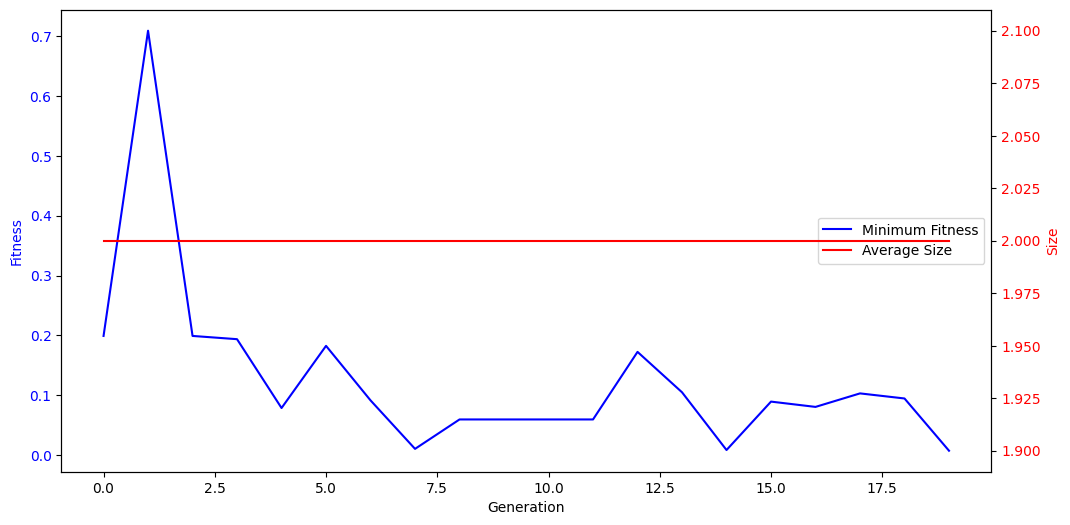

In [18]:
gen = logbook.select("gen")
fit_mins = logbook.chapters["fitness"].select("min")
size_avgs = logbook.chapters["size"].select("avg")

fig, ax1 = plt.subplots(figsize=(12, 6))
line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, size_avgs, "r-", label="Average Size")
ax2.set_ylabel("Size", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")

plt.show()

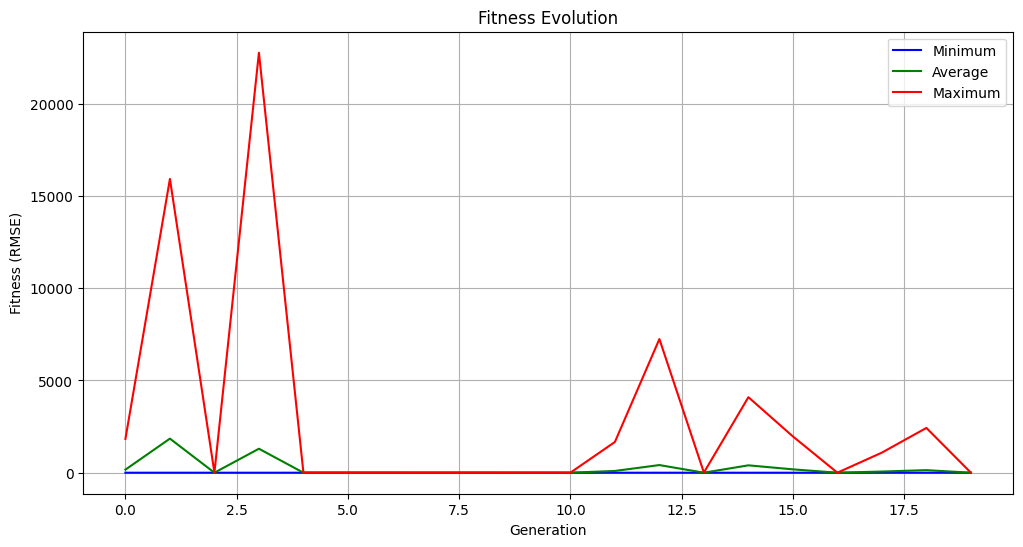

In [12]:
# Plot min, avg, max fitness over generations
plt.figure(figsize=(12, 6))
plt.plot(logbook.select("gen"), logbook.chapters["fitness"].select("min"), 'b-', label='Minimum')
plt.plot(logbook.select("gen"), logbook.chapters["fitness"].select("avg"), 'g-', label='Average')
plt.plot(logbook.select("gen"), logbook.chapters["fitness"].select("max"), 'r-', label='Maximum')
plt.xlabel('Generation')
plt.ylabel('Fitness (RMSE)')
plt.title('Fitness Evolution')
plt.legend()
plt.grid(True)
plt.show()

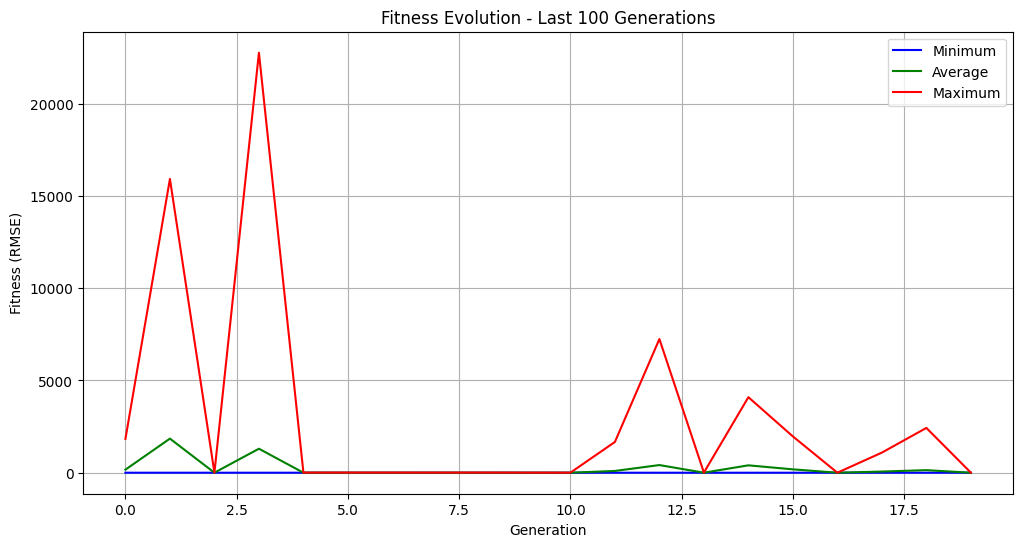

In [13]:
# Plot the last 100 generations
genZoom = 100
plt.figure(figsize=(12, 6))
generations = logbook.select("gen")
num_gens = len(generations)
start_idx = max(0, num_gens - genZoom)  # Start from 'genZoom' generations before the end or 0

# Extract data for the last 100 generations
last_gens = generations[start_idx:]
min_fitness = logbook.chapters["fitness"].select("min")[start_idx:]
avg_fitness = logbook.chapters["fitness"].select("avg")[start_idx:]
max_fitness = logbook.chapters["fitness"].select("max")[start_idx:]

# Plot the fitness curves
plt.plot(last_gens, min_fitness, 'b-', label='Minimum')
plt.plot(last_gens, avg_fitness, 'g-', label='Average')
plt.plot(last_gens, max_fitness, 'r-', label='Maximum')

plt.xlabel('Generation')
plt.ylabel('Fitness (RMSE)')
plt.title(f'Fitness Evolution - Last {genZoom} Generations')
plt.legend()
plt.grid(True)
plt.show()

## Extract the best individuals in the Hall of Fame

In [14]:
print(f"\n============  Hall Of Fame ==============\n")
# Specify the number of decimal places for the "Age" column
floatfmt = [".14f", ".14f", ".14f"]
header_HoF = ["Fitness", "Q", "R"]
values_HoF = []
best_individual = halloffame[0]
best_q, best_r = best_individual
#best_f, best_h, best_q, best_r = best_individual
best_fitness = float(best_individual.fitness.values[0])
values_HoF.append([best_fitness,best_q, best_r])
print("Best Individual:")
print(f"Individual: {best_individual}")
print(tabulate(values_HoF, headers=header_HoF, tablefmt="simple_outline", floatfmt=floatfmt))
#print(f"Best Q: {best_q}, Best R: {best_r}, Fitness: {best_fitness}")
#print(f"Best F: {best_f}, Best H: {best_h}, Best Q: {best_q}, Best R: {best_r}, Fitness: {best_fitness}")

print("\nNext Best Individuals:")

values_HoF = []
for individual in halloffame[1:]:
    q, r = individual
    #f,h,q, r = individual
    fitness = float(individual.fitness.values[0])
    values_HoF.append([fitness,q, r])
print(tabulate(values_HoF, headers=header_HoF, tablefmt="simple_outline", floatfmt=floatfmt))

print(f"\n===== Best Individual Performance =====\n")

# Create filter with optimal parameters
optimal_F = np.array([[1]])
optimal_H = np.array([[1]])
#optimal_F = np.array([[best_f]])
#optimal_H = np.array([[best_h]])
optimal_Q = np.array([[best_q]])
optimal_R = np.array([[best_r]])
P = np.array([[0]])
x = np.array([[0]])
optimal_kf = KalmanFilter(optimal_F, optimal_H, optimal_Q, optimal_R, P, x)
optimal_filtered = optimal_kf.filter(noisy_signal)

# Calculate improvement over original parameters
original_mse, original_rmse = kf.calculate_error(true_signal, filtered_signal)
optimal_mse, optimal_rmse = kf.calculate_error(true_signal, optimal_filtered)
improvement = ((original_rmse - optimal_rmse) / original_rmse) * 100

print(f"Original RMSE: {original_rmse:.6f}")
print(f"Optimal RMSE: {optimal_rmse:.6f}")
print(f"Improvement: {improvement:.2f}%")

true_signal_rms_value = kf.calculate_rms_value(true_signal)
filtered_signal_rms_value = kf.calculate_rms_value(filtered_signal)
rms_value_error = kf.calculate_rms_value_error(true_signal, filtered_signal)
optimal_signal_rms_value = kf.calculate_rms_value(optimal_filtered)
optimal_error = kf.calculate_rms_value_error(true_signal, optimal_filtered)
rms_value_error_improvement = ((rms_value_error - optimal_error) / rms_value_error)*100
print(f'True Signal RMS Value: {true_signal_rms_value:.6f}')
print(f'Filtered Signal RMS Value: {filtered_signal_rms_value:.6f}')
print(f'RMS Value Error: {rms_value_error:.6f}')
print(f'Optimal Signal RMS Value: {optimal_signal_rms_value:.6f}')
print(f'Optimal Signal RMS Error: {optimal_error:.6f}')
print(f'Error Improvement: {rms_value_error_improvement:.2f}%')

print(f"\n=======================================\n")



============  Hall Of Fame ==============

Best Individual:
Individual: Individual('d', [97.19681622994295, 1228.6808486261725])
┌──────────────────┬───────────────────┬─────────────────────┐
│          Fitness │                 Q │                   R │
├──────────────────┼───────────────────┼─────────────────────┤
│ 0.00714910150767 │ 97.19681622994295 │ 1228.68084862617252 │
└──────────────────┴───────────────────┴─────────────────────┘

Next Best Individuals:
┌──────────────────┬───────────────────┬─────────────────────┐
│          Fitness │                 Q │                   R │
├──────────────────┼───────────────────┼─────────────────────┤
│ 0.00831027639410 │ 12.75057732404289 │ 1682.47729255274749 │
│ 0.04171753248410 │  2.47799817032488 │ 1703.00889760787686 │
│ 0.05942299497749 │ 13.36975144955257 │ 1683.41914377377179 │
│ 0.08039954141570 │ 13.64277565379261 │ 1682.39815426682094 │
└──────────────────┴───────────────────┴─────────────────────┘

===== Best Individual Perf

## Save the Hall of Fame results to a JSON file

In [15]:
# Create serializable data
hof_json_data = []
for idx, ind in enumerate(halloffame):
    q_val, r_val = ind
    #f_val, h_val, q_val, r_val = ind
    fitness = float(ind.fitness.values[0])

    hof_json_data.append({
        'rank': idx + 1,
        'individual': [q_val, r_val],
        #'individual': [f_val, h_val, q_val, r_val],
        'fitness': fitness
    })

# Create HallOfFame directory if it doesn't exist
hof_dir = "HallOfFame"
if not os.path.exists(hof_dir):
    os.makedirs(hof_dir)
    print(f"Created directory: {hof_dir}")

# Get current date and time in YYYYMMDD-HHMMSS format
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Save to JSON file with timestamp in filename
filename = os.path.join(hof_dir, f'{timestamp}_halloffame_results.json')
with open(filename, 'w') as f:
    json.dump(hof_json_data, f, indent=4)

print(f"Hall of Fame results saved to {filename}")

Hall of Fame results saved to HallOfFame\20250324-000213_halloffame_results.json


## Test The Kalman Filter with the best parameters

Original RMSE: 0.230516
Optimal RMSE: 0.196182
Improvement: 14.89%
True Signal RMS Value: 0.140855
Filtered Signal RMS Value: 0.263582
RMS Value Error: 0.122727
Optimal Signal RMS Value: 0.228767
Optimal Signal RMS Error: 0.087913
Error Improvement: 28.37%


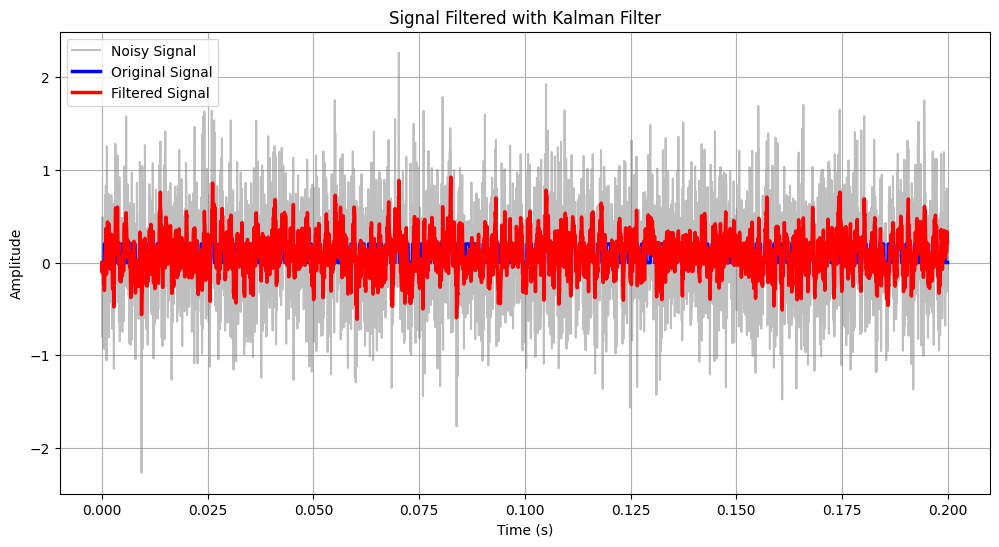

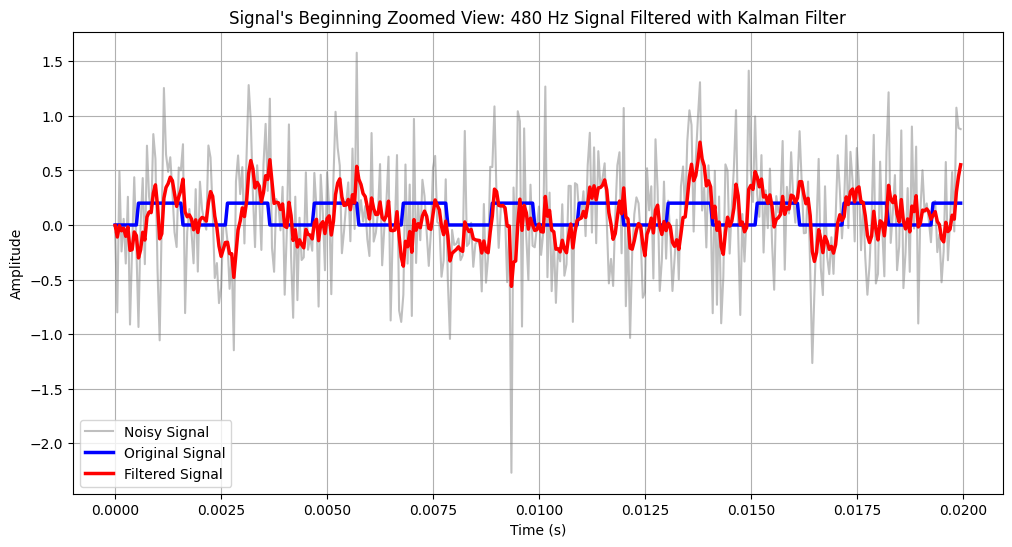

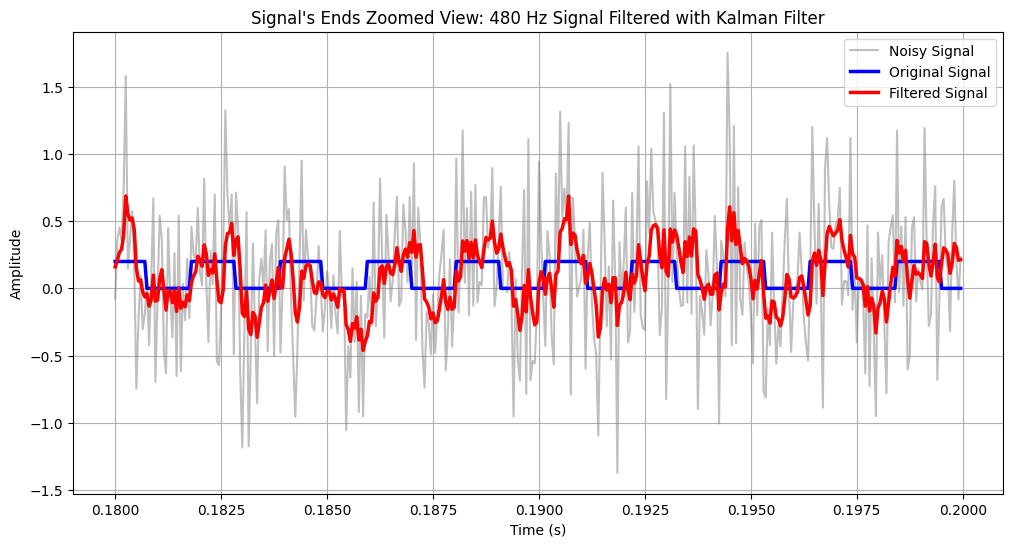

In [16]:
# Add noise to create noisy measurement
noise_std = 0.5
noisy_signal = SigGen.add_noise(true_signal, noise_std)

# Initialize Optimized Kalman filter
optimal_F = np.array([[1]])
optimal_H = np.array([[1]])
#optimal_F = np.array([[best_f]])
#optimal_H = np.array([[best_h]])
optimal_Q = np.array([[best_q]])
optimal_R = np.array([[best_r]])
P = np.array([[0]])  #
x = np.array([[0]])

# Create and apply filter
kf = KalmanFilter(optimal_F, optimal_H, optimal_Q, optimal_R, P, x)
optimal_filtered = kf.filter(noisy_signal)

# Calculate improvement over original parameters
original_mse, original_rmse = kf.calculate_error(true_signal, filtered_signal)
optimal_mse, optimal_rmse = kf.calculate_error(true_signal, optimal_filtered)
improvement = ((original_rmse - optimal_rmse) / original_rmse) * 100

print(f"Original RMSE: {original_rmse:.6f}")
print(f"Optimal RMSE: {optimal_rmse:.6f}")
print(f"Improvement: {improvement:.2f}%")

true_signal_rms_value = kf.calculate_rms_value(true_signal)
filtered_signal_rms_value = kf.calculate_rms_value(filtered_signal)
rms_value_error = kf.calculate_rms_value_error(true_signal, filtered_signal)
optimal_signal_rms_value = kf.calculate_rms_value(optimal_filtered)
optimal_error = kf.calculate_rms_value_error(true_signal, optimal_filtered)
rms_value_error_improvement = ((rms_value_error - optimal_error) / rms_value_error)*100
print(f'True Signal RMS Value: {true_signal_rms_value:.6f}')
print(f'Filtered Signal RMS Value: {filtered_signal_rms_value:.6f}')
print(f'RMS Value Error: {rms_value_error:.6f}')
print(f'Optimal Signal RMS Value: {optimal_signal_rms_value:.6f}')
print(f'Optimal Signal RMS Error: {optimal_error:.6f}')
print(f'Error Improvement: {rms_value_error_improvement:.2f}%')

# Plot results
kf.plot_results(noisy_signal, true_signal, optimal_filtered, time)
kf.plot_results(noisy_signal, true_signal, optimal_filtered, time, zoom_end=0.1, title=f'Signal\'s Beginning Zoomed View: {frequency} Hz Signal Filtered with Kalman Filter')
kf.plot_results(noisy_signal, true_signal, optimal_filtered, time, zoom_begin=0.9, title=f'Signal\'s Ends Zoomed View: {frequency} Hz Signal Filtered with Kalman Filter')